In [1]:
from pathlib import Path
import sys  
import os
import pandas as pd 
from datetime import datetime
import scipy.sparse as sps
from numpy import linalg as LA

import numpy as np
from operator import itemgetter

In [2]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "libs")))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from Utils.load_URM import load_URM
from Utils.load_ICM import load_ICM

from scipy.sparse import hstack, vstack
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_all = load_URM("../data/data_train.csv")
ICM_all = load_ICM("../data/data_ICM_metadata.csv")

In [5]:
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)

In [6]:
evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])

EvaluatorHoldout: Ignoring 182 ( 0.5%) Users that have less than 1 test interactions


In [7]:
from libs.Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender 
from libs.Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender

In [21]:
slim_model = SLIMElasticNetRecommender(URM_train)
slim_model2 = SLIMElasticNetRecommender(URM_train)

In [24]:
slim_model.load_model('result_experiments/SLIM/', 'slim_300_2_weights')
slim_model2.load_model('result_experiments/SLIM/', 'slim_urm_300_3_weights')

SLIMElasticNetRecommender: Loading model from file 'result_experiments/SLIM/slim_300_2_weights'
SLIMElasticNetRecommender: Loading complete
SLIMElasticNetRecommender: Loading model from file 'result_experiments/SLIM/slim_urm_300_3_weights'
SLIMElasticNetRecommender: Loading complete


In [28]:
rp3_model = RP3betaRecommender(URM_all)
rp3_model.fit(alpha=0.4, beta=0.25,	min_rating=0.0,	topK=10, implicit=False, normalize_similarity=True)

RP3betaRecommender: Similarity column 38121 (100.0%), 3788.01 column/sec. Elapsed time 10.06 sec


In [29]:
rp3_model.save_model('result_experiments/RP3beta/', 'rp3beta_10_weights')

RP3betaRecommender: Saving model in file 'result_experiments/RP3beta/rp3beta_10_weights'
RP3betaRecommender: Saving complete


In [10]:
rp3_model = RP3betaRecommender(URM_train)
rp3_model.load_model('result_experiments/RP3beta/', 'rp3beta_10_weights')

RP3betaRecommender: Loading model from file 'result_experiments/RP3beta/rp3beta_10_weights'
RP3betaRecommender: Loading complete


In [11]:
result_dict_slim, _ = evaluator_validation.evaluateRecommender(slim_model)

EvaluatorHoldout: Processed 35554 (100.0%) in 15.08 sec. Users per second: 2358


In [12]:
result_dict_rp3, _ = evaluator_validation.evaluateRecommender(rp3_model)

EvaluatorHoldout: Processed 35554 (100.0%) in 9.15 sec. Users per second: 3887


In [13]:
result_dict_slim["MAP"]

cutoff
10    0.133204
Name: MAP, dtype: object

In [14]:
result_dict_rp3["MAP"]

cutoff
10    0.092349
Name: MAP, dtype: object

In [19]:
rp3_model._compute_item_score(10)

(1, 38121)

In [20]:
slim_model._compute_item_score(10)

(1, 38121)

In [41]:
from Recommenders.BaseRecommender import BaseRecommender

class DifferentLossScoresHybridRecommender(BaseRecommender):
    """ ScoresHybridRecommender
    Hybrid of two prediction scores R = R1/norm*alpha + R2/norm*(1-alpha) where R1 and R2 come from
    algorithms trained on different loss functions.

    """

    RECOMMENDER_NAME = "DifferentLossScoresHybridRecommender"


    def __init__(self, URM_train, recommender_1, recommender_2):
        super(DifferentLossScoresHybridRecommender, self).__init__(URM_train)

        self.URM_train = sps.csr_matrix(URM_train)
        self.recommender_1 = recommender_1
        self.recommender_2 = recommender_2
        
        
        
    def fit(self, norm, alpha = 0.5):

        self.alpha = alpha
        self.norm = norm


    def _compute_item_score(self, user_id_array, items_to_compute):
        
        item_weights_1 = self.recommender_1._compute_item_score(user_id_array)
        item_weights_2 = self.recommender_2._compute_item_score(user_id_array)

        norm_item_weights_1 = LA.norm(item_weights_1, self.norm)
        norm_item_weights_2 = LA.norm(item_weights_2, self.norm)
        
        
        if norm_item_weights_1 == 0:
            raise ValueError("Norm {} of item weights for recommender 1 is zero. Avoiding division by zero".format(self.norm))
        
        if norm_item_weights_2 == 0:
            raise ValueError("Norm {} of item weights for recommender 2 is zero. Avoiding division by zero".format(self.norm))
        
        item_weights = item_weights_1 / norm_item_weights_1 * self.alpha + item_weights_2 / norm_item_weights_2 * (1-self.alpha)
        #item_weights = item_weights_1 / norm_item_weights_1  + item_weights_2 / norm_item_weights_2

        return item_weights



In [19]:
np.linspace(0.05, 0.95, 20)

array([0.05      , 0.09736842, 0.14473684, 0.19210526, 0.23947368,
       0.28684211, 0.33421053, 0.38157895, 0.42894737, 0.47631579,
       0.52368421, 0.57105263, 0.61842105, 0.66578947, 0.71315789,
       0.76052632, 0.80789474, 0.85526316, 0.90263158, 0.95      ])

In [21]:
max_MAP = -1 

In [ ]:
recommender_object = DifferentLossScoresHybridRecommender(URM_train, slim_model, rp3_model)

for norm in [1, 2, np.inf, -np.inf]:
    for alpha in np.linspace(0.05, 0.95, 20):
        recommender_object.fit(norm, alpha = alpha)
        result_df, _ = evaluator_validation.evaluateRecommender(recommender_object)
        if result_df.loc[10]["MAP"] > max_MAP:
            max_MAP = result_df.loc[10]["MAP"]
        print("Norm: {}, alpha: {}, Result: {}, max_MAP: {}".format(norm, alpha, result_df.loc[10]["MAP"], max_MAP))

EvaluatorHoldout: Processed 35574 (100.0%) in 18.32 sec. Users per second: 1942
Norm: 1, alpha: 0.05, Result: 0.09496227291913586, max_MAP: 0.11639401904012134
EvaluatorHoldout: Processed 35574 (100.0%) in 18.27 sec. Users per second: 1948
Norm: 1, alpha: 0.09736842105263158, Result: 0.0963582161842812, max_MAP: 0.11639401904012134
EvaluatorHoldout: Processed 35574 (100.0%) in 18.17 sec. Users per second: 1958
Norm: 1, alpha: 0.14473684210526316, Result: 0.09774940075728386, max_MAP: 0.11639401904012134
EvaluatorHoldout: Processed 35574 (100.0%) in 18.09 sec. Users per second: 1966
Norm: 1, alpha: 0.19210526315789472, Result: 0.09920441717287493, max_MAP: 0.11639401904012134
EvaluatorHoldout: Processed 35574 (100.0%) in 18.14 sec. Users per second: 1961
Norm: 1, alpha: 0.23947368421052628, Result: 0.10070083398700984, max_MAP: 0.11639401904012134
EvaluatorHoldout: Processed 35574 (100.0%) in 18.38 sec. Users per second: 1935
Norm: 1, alpha: 0.28684210526315784, Result: 0.10227662480445

In [42]:
recommender_object = DifferentLossScoresHybridRecommender(URM_train, slim_model, rp3_model)

In [43]:
recommender_object.fit(1, alpha = 0.95)

In [19]:
def write_submission_lib_model(trained_model, filename: str = "submission.csv") -> None:
	"""Builds the submission file from a trained recommender model. The file is saved in a CSV format.

	:param trained_model: A fitted recommender model
	:type trained_model: RecommenderModel
	:param filename: The filename of the submission for this particular recommender model
	:type filename: str
	"""
	target_users_test = pd.read_csv("../data/data_target_users_test.csv",).to_numpy().ravel()

	recommendations = np.array([
		trained_model.recommend(user_id, cutoff=10) for user_id in target_users_test
	])

	if not os.path.exists("../submissions"):
		os.makedirs("../submissions")
	with open(f"../submissions/{filename}", "w") as f:
		f.write("user_id,item_list\n")
		for user_id, recs in zip(target_users_test, recommendations):
			f.write(f"{user_id},{' '.join(map(str, recs))}\n")

In [46]:
write_submission_lib_model(recommender_object2, "slim_slim.csv")

In [21]:
import seaborn as sns
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

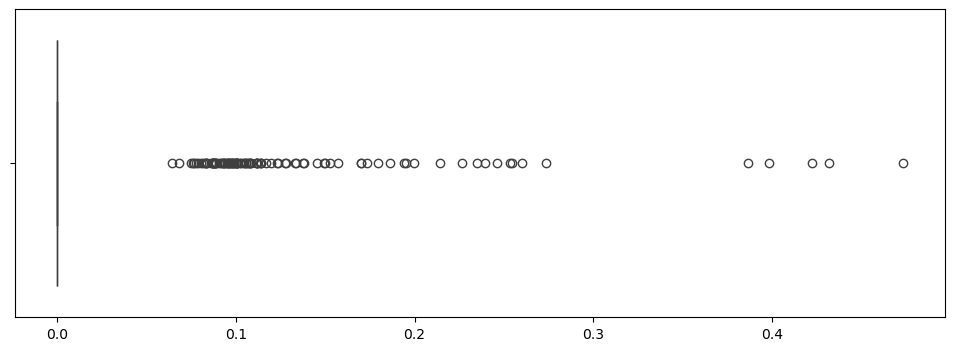

In [27]:
_ = plt.figure(figsize=(12,4))
ax = sns.boxplot(x=rp3_model._compute_item_score(10).flatten())

In [ ]:
assa

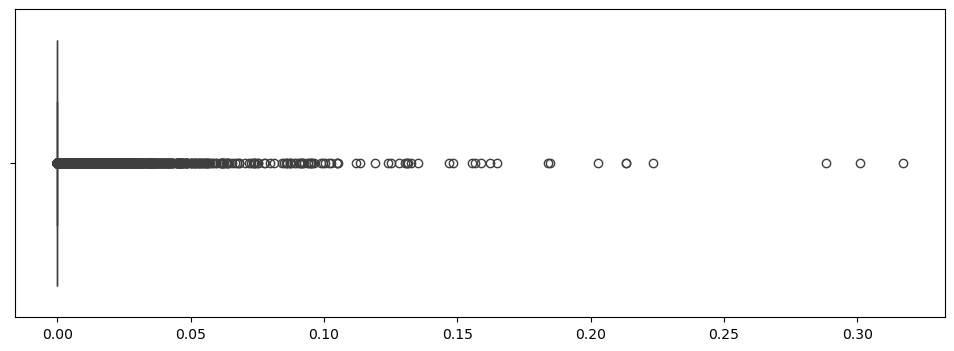

In [26]:
_ = plt.figure(figsize=(12,4))
ax = sns.boxplot(x=slim_model._compute_item_score(10).flatten())

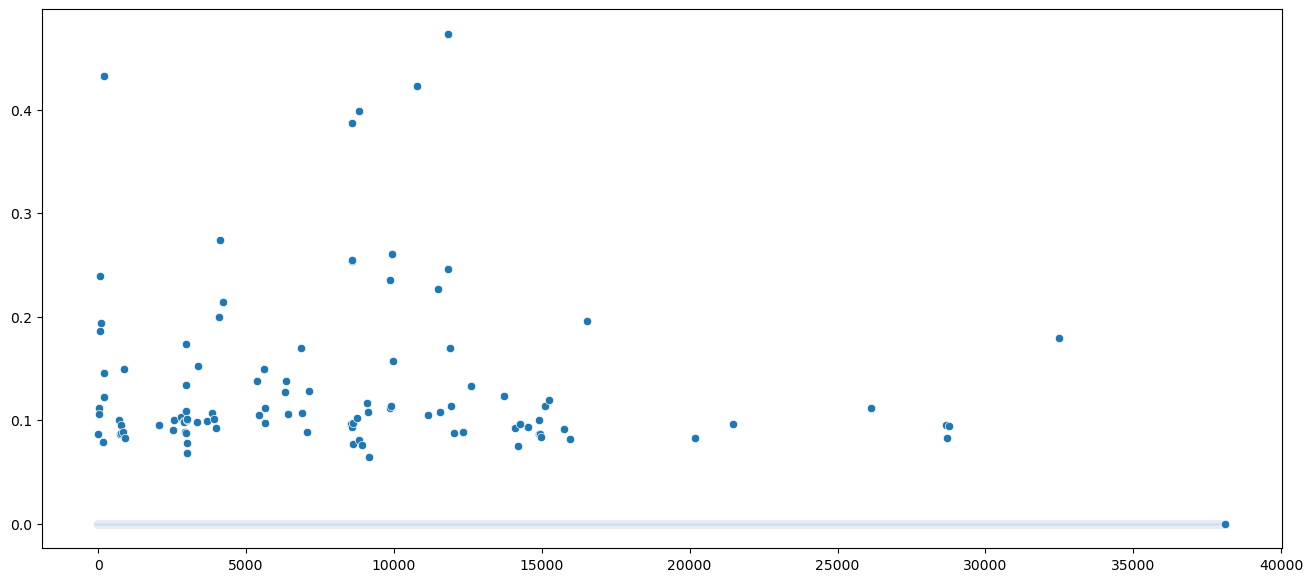

In [28]:
_ = plt.figure(figsize=(16,7))
ax = sns.scatterplot(data=rp3_model._compute_item_score(10).flatten())

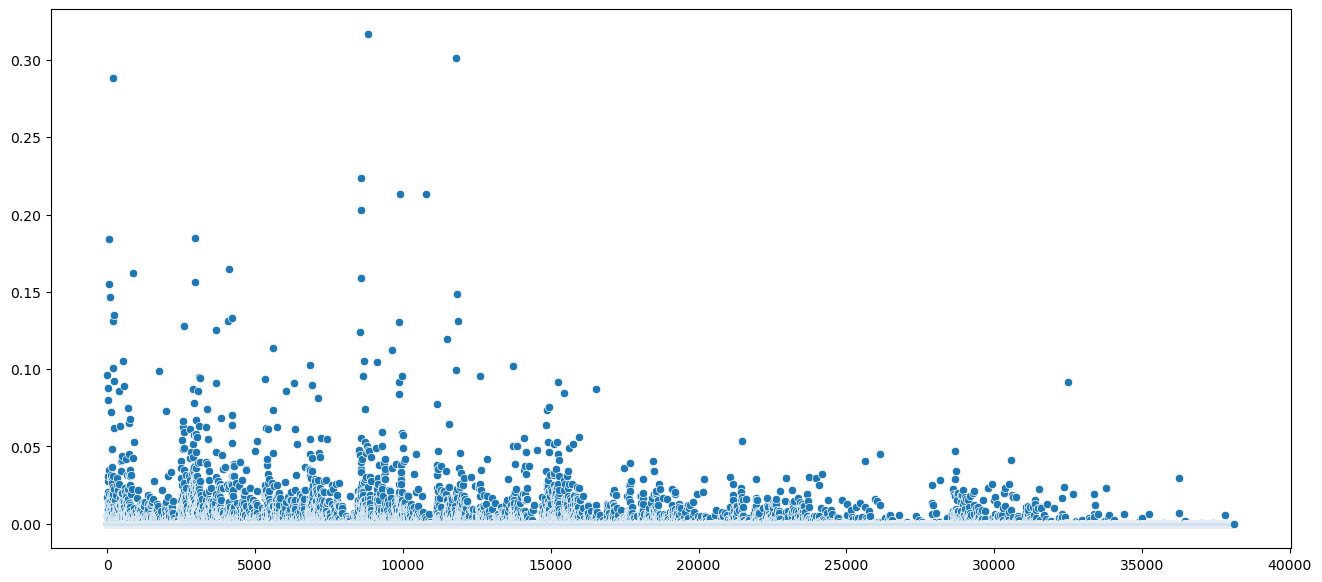

In [29]:
_ = plt.figure(figsize=(16,7))
ax = sns.scatterplot(data=slim_model._compute_item_score(10).flatten())

In [36]:
recommender_object2 = DifferentLossScoresHybridRecommender(URM_train, slim_model, slim_model2)

In [37]:
recommender_object2.fit(norm=1, alpha = 10000000)

In [38]:
result_df, _ = evaluator_validation.evaluateRecommender(recommender_object2)

EvaluatorHoldout: Processed 35554 (100.0%) in 21.90 sec. Users per second: 1624


In [45]:
result_df["MAP"]

cutoff
10    0.130966
Name: MAP, dtype: object